In [1]:
import numpy as np
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

from skopt.benchmarks import branin
from skopt import Optimizer
from pyDOE import *

/Users/nimishawalgaonkar/anaconda2/envs/scikit_optimize_develop/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<Figure size 432x288 with 0 Axes>

In [2]:
def neg_branin(x):
    y = -1*branin(x)
    return y

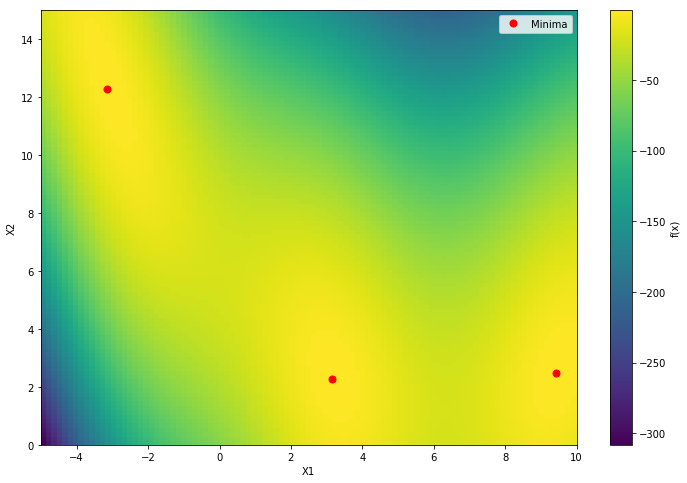

In [3]:
from matplotlib.colors import LogNorm

def plot_neg_branin_with_maxima():
    fig, ax = plt.subplots(figsize = (12,8))

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([neg_branin(val) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx)

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    plt.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")

    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])

plot_neg_branin_with_maxima()

In [4]:
def plot_neg_branin_with_points(X):
    fig, ax = plt.subplots(figsize = (12,8))

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([neg_branin(val) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx)
    ax.plot(X[:,0], X[:, 1], "k.", markersize=14, lw=0, label="points")
    
    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    plt.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")

    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])

In [5]:
ntrain = 50 # number of initial training points
d = 2 # number of dimensions of the input features

X_train_norm = lhs(2, samples= ntrain, criterion='maximin') # Initial training points
X_train = np.zeros(X_train_norm.shape)
X_train[:,0] = X_train_norm[:,0]*15 - 5.
X_train[:,1] = X_train_norm[:,1]*15
Y_train = neg_branin(X_train.T)
bounds = [(-5.0, 10.0), (0.0, 15.0)]

In [6]:
opt = Optimizer(bounds)

In [7]:
opt.tell(X_train.tolist(), Y_train.tolist())

          fun: -218.0782325571445
    func_vals: array([ -38.02139204,   -6.84686835,   -3.84769098,  -46.59864996,
       -106.03068841,  -17.26558586,  -57.94172046,  -12.99403395,
        -37.08600539,  -33.22398312, -138.778057  ,  -44.41353045,
        -20.17648984,  -15.83438464,  -16.37311789,  -21.60955363,
       -177.84822597, -101.88955032,  -59.36459719,  -17.42976814,
        -29.01136075, -137.9990274 ,  -47.63844269,  -15.39186586,
        -28.03105857,  -60.11433157,  -17.99784872, -113.18550174,
        -43.29446292,  -98.12992219,  -26.65863116, -170.3432751 ,
        -30.36408375,  -18.13490032,   -9.10906695,   -3.83218899,
         -6.91201808,   -0.45499341,  -87.91668479,  -53.59800883,
       -171.20195916,  -84.1924601 ,  -26.90390004,  -70.32490478,
       -218.07823256,  -53.36640107,  -39.32534174,  -11.68385873,
        -94.2446718 ,   -3.72747342])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(le

In [8]:
model = opt.models[-1]

In [9]:
x1_values = np.linspace(-5, 10, 100)
x2_values = np.linspace(0, 15, 100)
x_ax, y_ax = np.meshgrid(x1_values, x2_values)
X_grid = np.zeros(shape = (x_ax.ravel().shape[0], 2))
X_grid[:,0] = x_ax.ravel()
X_grid[:,1] = y_ax.ravel()
x_model = opt.space.transform(X_grid.tolist())

In [10]:
from rpy2.robjects.packages import STAP

In [11]:
with open('qEI_call.r', 'r') as f:
    string = f.read()
qEI = STAP(string, "qEI_call")

In [12]:
num_dim = 2
num_test_batches = 10000
num_sampled_points = 3
sampling_strategy = 'LHS'
norm = True # we need to do unnormalization of LHS sampled points

In [13]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [14]:
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri as rpyn
rcpp = importr("Rcpp")
rcpp.sourceCpp('qEI.cpp')
batches = []
max_obj = np.max(Y_train)
cc_vec = np.zeros(num_test_batches)
for i in range(num_test_batches):
    if sampling_strategy == 'LHS': 
        b = lhs(num_dim, num_sampled_points)
    else:
        print ("No such sampling strategy exists ..")
    
    if norm == True:
        #print ('Unnormalizing the LHS sampling based points')
        b[:,0] = b[:,0]*15 - 5.
        b[:,1] = b[:,1]*15
    else:
        b = b
        
    b_model = opt.space.transform(b.tolist())
    batches.append(b)
    mean, covar = model.predict(b_model, return_cov=True)
    cc = qEI.qEI_approx(mean, covar, max_obj)
    cc_num = rpyn.ri2py(cc)
    cc_vec[i] = cc_num

max_qEI_val = np.max(cc_vec)
max_qEI_val_ind = np.argmax(cc_vec)
best_batch = batches[max_qEI_val_ind]

### Actual Branin function

In [ ]:
plot_neg_branin_with_points(np.array(best_batch))

### GP Predictions

In [ ]:
y_pred, sigma = model.predict(x_model, return_std=True)

In [ ]:
r = model.predict(x_model, return_cov = True)

In [ ]:
r[1].shape

In [ ]:
def plot_neg_branin_pred(X, y_pred, x1_values, x2_values):
    fig, ax = plt.subplots(figsize = (12,8))
    fx = np.reshape(y_pred, (100, 100))
    cm = ax.pcolormesh(x1_values, x2_values, fx)

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")
    ax.plot(X[:,0], X[:, 1], "k.", markersize=14, lw=0, label="points")

    cb = fig.colorbar(cm)
    cb.set_label("m(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])
    
    
def plot_neg_branin_var(X, sigma, x1_values, x2_values):
    fig, ax = plt.subplots(figsize = (12,8))
    fx = np.reshape(sigma, (100, 100))
    cm = ax.pcolormesh(x1_values, x2_values, fx)

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")
    ax.plot(X[:,0], X[:, 1], "k.", markersize=14, lw=0, label="points")
    cb = fig.colorbar(cm)
    cb.set_label("sigma(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])

In [ ]:
plot_neg_branin_pred(np.array(best_batch), y_pred, x1_values, x2_values)

In [ ]:
plot_neg_branin_var(np.array(best_batch), sigma, x1_values, x2_values)

# Debug 1 : Check the qEI value for actual optimum point and compare 

In [ ]:
minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
min_model = opt.space.transform(minima.tolist())
mean, covar = model.predict(min_model, return_cov=True)
cd = qEI.qEI_approx(mean, covar, max_obj)
opt_num = rpyn.ri2py(cd)

In [ ]:
opt_num

In [ ]:
np.max(cc_vec)

In [ ]:
cc_vec[np.argsort(cc_vec)[-20:]]

This test fails since the qEI value associated with actual optimum is less than other qEI values.

Let see if we get the same results when number of training data = 200.

In [ ]:
ntrain = 200 # number of initial training points
d = 2 # number of dimensions of the input features

X_train_norm = lhs(2, samples= ntrain, criterion='maximin') # Initial training points
X_train = np.zeros(X_train_norm.shape)
X_train[:,0] = X_train_norm[:,0]*15 - 5.
X_train[:,1] = X_train_norm[:,1]*15
Y_train = neg_branin(X_train.T)
bounds = [(-5.0, 10.0), (0.0, 15.0)]

opt = Optimizer(bounds)
opt.tell(X_train.tolist(), Y_train.tolist())
model = opt.models[-1]

x1_values = np.linspace(-5, 10, 100)
x2_values = np.linspace(0, 15, 100)
x_ax, y_ax = np.meshgrid(x1_values, x2_values)
X_grid = np.zeros(shape = (x_ax.ravel().shape[0], 2))
X_grid[:,0] = x_ax.ravel()
X_grid[:,1] = y_ax.ravel()
x_model = opt.space.transform(X_grid.tolist())

In [ ]:
num_dim = 2
num_test_batches = 10000
num_sampled_points = 3
sampling_strategy = 'LHS'
norm = True # we need to do unnormalization of LHS sampled points

In [ ]:
rcpp = importr("Rcpp")
rcpp.sourceCpp('qEI.cpp')
batches = []
max_obj = np.max(Y_train)
cc_vec = np.zeros(num_test_batches)
for i in range(num_test_batches):
    if sampling_strategy == 'LHS': 
        b = lhs(num_dim, num_sampled_points)
    else:
        print ("No such sampling strategy exists ..")
    
    if norm == True:
        #print ('Unnormalizing the LHS sampling based points')
        b[:,0] = b[:,0]*15 - 5.
        b[:,1] = b[:,1]*15
    else:
        b = b
        
    b_model = opt.space.transform(b.tolist())
    batches.append(b)
    mean, covar = model.predict(b_model, return_cov=True)
    cc = qEI.qEI_approx(mean, covar, max_obj)
    cc_num = rpyn.ri2py(cc)
    cc_vec[i] = cc_num

max_qEI_val = np.max(cc_vec)
max_qEI_val_ind = np.argmax(cc_vec)
best_batch = batches[max_qEI_val_ind]

In [ ]:
plot_neg_branin_with_points(np.array(best_batch))
plot_neg_branin_pred(np.array(best_batch), y_pred, x1_values, x2_values)
plot_neg_branin_var(np.array(best_batch), sigma, x1_values, x2_values)

In [ ]:
np.max(cc_vec)

In [ ]:
minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
min_model = opt.space.transform(minima.tolist())
mean, covar = model.predict(min_model, return_cov=True)
cd = qEI.qEI_approx(mean, covar, max_obj)
opt_num = rpyn.ri2py(cd)

In [ ]:
opt_num

This works. The qEI score for the actual optimum is greater than the best qEI value found from the batches which is what we expect. This is good.

Let's see what happens with more batches. Will any perform better than the optimum?

In [ ]:
num_dim = 2
num_test_batches = 50000
num_sampled_points = 3
sampling_strategy = 'LHS'
norm = True # we need to do unnormalization of LHS sampled points

rcpp = importr("Rcpp")
rcpp.sourceCpp('qEI.cpp')
batches = []
max_obj = np.max(Y_train)
cc_vec = np.zeros(num_test_batches)
for i in range(num_test_batches):
    if sampling_strategy == 'LHS': 
        b = lhs(num_dim, num_sampled_points)
    else:
        print ("No such sampling strategy exists ..")
    
    if norm == True:
        #print ('Unnormalizing the LHS sampling based points')
        b[:,0] = b[:,0]*15 - 5.
        b[:,1] = b[:,1]*15
    else:
        b = b
        
    b_model = opt.space.transform(b.tolist())
    batches.append(b)
    mean, covar = model.predict(b_model, return_cov=True)
    cc = qEI.qEI_approx(mean, covar, max_obj)
    cc_num = rpyn.ri2py(cc)
    cc_vec[i] = cc_num

max_qEI_val = np.max(cc_vec)
max_qEI_val_ind = np.argmax(cc_vec)
best_batch = batches[max_qEI_val_ind]

In [ ]:
np.max(cc_vec)

Till no progress : which means that approximation to qEI is working.

**Second question now is : how should we select these batches? Is there an intelligent way to do this?**

# Debug 2 : Checking approx. qEI values with actual qEI from DiceOptim

# Debug 3 : Checking how new batches will be elicited with approx qEI

In [ ]:
X_train.shape

In [ ]:
ntrain = 200 # number of initial training points
d = 2 # number of dimensions of the input features

X_train_norm = lhs(2, samples= ntrain, criterion='maximin') # Initial training points
X_train = np.zeros(X_train_norm.shape)
X_train[:,0] = X_train_norm[:,0]*15 - 5.
X_train[:,1] = X_train_norm[:,1]*15
Y_train = neg_branin(X_train.T)
bounds = [(-5.0, 10.0), (0.0, 15.0)]

In [ ]:
num_dim = 2
num_test_batches = 400
num_sampled_points = 3
num_iter = 10

sampling_strategy = 'manual'
norm = False # we need to do unnormalization of LHS sampled points

Xt = X_train
Yt = Y_train

bb = []
sc = []
bb_array = np.empty((0, 2))
for j in range(num_iter):
    print('Elicitation has started. Eliciting batch num:' + str(j))
    max_obj = np.max(Yt)
    # Train the model on the previous data
    OOPT = Optimizer(bounds)
    OOPT.tell(Xt.tolist(), Yt.tolist())
    model = opt.models[-1]
    
    
    batches = []
    cc_vec = np.zeros(num_test_batches)
    for i in range(num_test_batches):
        if sampling_strategy == 'LHS': 
            b = lhs(num_dim, num_sampled_points)
            
        if sampling_strategy == 'manual':
            x1_values = np.linspace(-5, 10, 200)
            x2_values = np.linspace(0, 15, 200)
            x_ax, y_ax = np.meshgrid(x1_values, x2_values)
            X_grid = np.zeros(shape = (x_ax.ravel().shape[0], 2))
            X_grid[:,0] = x_ax.ravel()
            X_grid[:,1] = y_ax.ravel()
            rel_ind = np.random.choice(X_grid.shape[0], num_sampled_points, replace=False)
            b = X_grid[rel_ind,:]
        else:
            print ("No such sampling strategy exists ..")
    
        if norm == True:
            #print ('Unnormalizing the LHS sampling based points')
            b[:,0] = b[:,0]*15 - 5.
            b[:,1] = b[:,1]*15
        else:
            b = b
        
        b_model = opt.space.transform(b.tolist())
        batches.append(b)
        mean, covar = model.predict(b_model, return_cov=True)
        cc = qEI.qEI_approx(mean, covar, max_obj)
        cc_num = rpyn.ri2py(cc)
        cc_vec[i] = cc_num

    max_qEI_val = np.max(cc_vec)
    max_qEI_val_ind = np.argmax(cc_vec)
    best_batch = batches[max_qEI_val_ind]
    bb.append(best_batch)
    Xt = np.vstack([Xt, best_batch])
    y = neg_branin(np.array(best_batch).T)
    Yt = np.append(Yt, y)
    
    bb_array = np.vstack([bb_array, best_batch])
    
    plot_neg_branin_with_points(bb_array)
    #plot_neg_branin_pred(np.array(best_batch), y_pred, x1_values, x2_values)
    #plot_neg_branin_var(np.array(best_batch), sigma, x1_values, x2_values)

In [ ]:
minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
min_model = opt.space.transform(minima.tolist())
mean, covar = model.predict(min_model, return_cov=True)
cd = qEI.qEI_approx(mean, covar, max_obj)
opt_num = rpyn.ri2py(cd)

In [ ]:
op

In [ ]:
X_grid_model = opt.space.transform(X_grid.tolist())
mean, covar = model.predict(X_grid_model, return_cov=True)

In [ ]:
b.shape

In [ ]:
X_train.shape

In [ ]:
y = neg_branin(X_train)

In [ ]:
bb_array = np.empty((0, 2))

In [ ]:
np.vstack([bb_array, best_batch])

In [ ]:
minima

In [ ]:
y = neg_branin(minima.T)

In [ ]:
y

Elicitation has started. Eliciting batch num:0
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling 

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy ex

Elicitation has started. Eliciting batch num:1
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling 

No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..
No such sampling strategy exists ..


KeyboardInterrupt: 

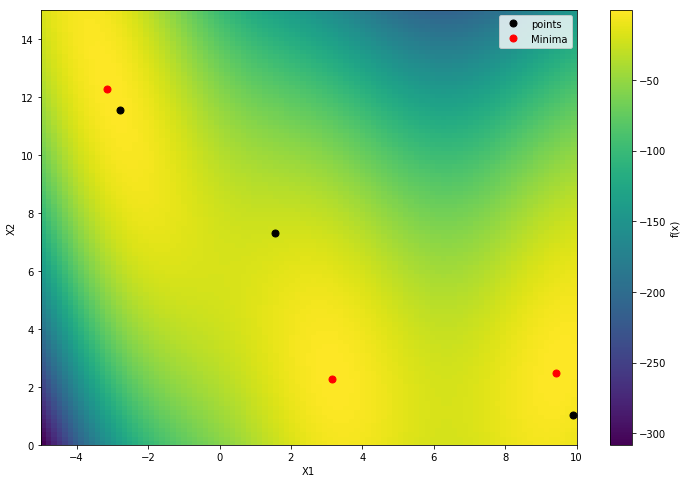

In [15]:
num_dim = 2
num_test_batches = 5000
num_sampled_points = 3
num_iter = 10

sampling_strategy = 'LHS'
norm = True # we need to do unnormalization of LHS sampled points

Xt = X_train
Yt = Y_train

bb = []
sc = []
bb_array = np.empty((0, 2))
for j in range(num_iter):
    print('Elicitation has started. Eliciting batch num:' + str(j))
    max_obj = np.max(Yt)
    # Train the model on the previous data
    OOPT = Optimizer(bounds)
    OOPT.tell(Xt.tolist(), Yt.tolist())
    model = opt.models[-1]
    
    
    batches = []
    cc_vec = np.zeros(num_test_batches)
    for i in range(num_test_batches):
        if sampling_strategy == 'LHS': 
            b = lhs(num_dim, num_sampled_points)
        if sampling_strategy == 'manual':
            x1_values = np.linspace(-5, 10, 200)
            x2_values = np.linspace(0, 15, 200)
            x_ax, y_ax = np.meshgrid(x1_values, x2_values)
            X_grid = np.zeros(shape = (x_ax.ravel().shape[0], 2))
            X_grid[:,0] = x_ax.ravel()
            X_grid[:,1] = y_ax.ravel()
            rel_ind = np.random.choice(X_grid.shape[0], num_sampled_points, replace=False)
            b = X_grid[rel_ind,:]
        else:
            print ("No such sampling strategy exists ..")
    
        if norm == True:
            #print ('Unnormalizing the LHS sampling based points')
            b[:,0] = b[:,0]*15 - 5.
            b[:,1] = b[:,1]*15
        else:
            b = b
        
        b_model = opt.space.transform(b.tolist())
        batches.append(b)
        mean, covar = model.predict(b_model, return_cov=True)
        cc = qEI.qEI_approx(mean, covar, max_obj)
        cc_num = rpyn.ri2py(cc)
        cc_vec[i] = cc_num
    
    
    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    min_model = opt.space.transform(minima.tolist())
    mean_min, covar_min = model.predict(min_model, return_cov=True)
    cd = qEI.qEI_approx(mean_min, covar_min, max_obj)
    opt_num = rpyn.ri2py(cd)
    
    batches.append(minima)
    cc_vec = np.append(cc_vec, opt_num)
    
    max_qEI_val = np.max(cc_vec)
    max_qEI_val_ind = np.argmax(cc_vec)
    best_batch = batches[max_qEI_val_ind]
    bb.append(best_batch)
    Xt = np.vstack([Xt, best_batch])
    y = neg_branin(np.array(best_batch).T)
    Yt = np.append(Yt, y)
    
    bb_array = np.vstack([bb_array, best_batch])
    
    plot_neg_branin_with_points(bb_array)
    #plot_neg_branin_pred(np.array(best_batch), y_pred, x1_values, x2_values)
    #plot_neg_branin_var(np.array(best_batch), sigma, x1_values, x2_values)

In [ ]:
x1_values = np.linspace(-5, 10, 200)
x2_values = np.linspace(0, 15, 200)
x_ax, y_ax = np.meshgrid(x1_values, x2_values)
X_grid = np.zeros(shape = (x_ax.ravel().shape[0], 2))
X_grid[:,0] = x_ax.ravel()
X_grid[:,1] = y_ax.ravel()

In [ ]:
index = np.arange(X_grid.shape[0])

In [ ]:
index

In [ ]:
rel_ind = np.random.choice(X_grid.shape[0], num_sampled_points, replace=False)

In [ ]:
Xrel = X_grid[rel_ind,:]

In [ ]:
Xrel

Elicitation has started. Eliciting batch num:0
Elicitation has started. Eliciting batch num:1
Elicitation has started. Eliciting batch num:2
Elicitation has started. Eliciting batch num:3
Elicitation has started. Eliciting batch num:4
Elicitation has started. Eliciting batch num:5
Elicitation has started. Eliciting batch num:6
Elicitation has started. Eliciting batch num:7
Elicitation has started. Eliciting batch num:8
Elicitation has started. Eliciting batch num:9


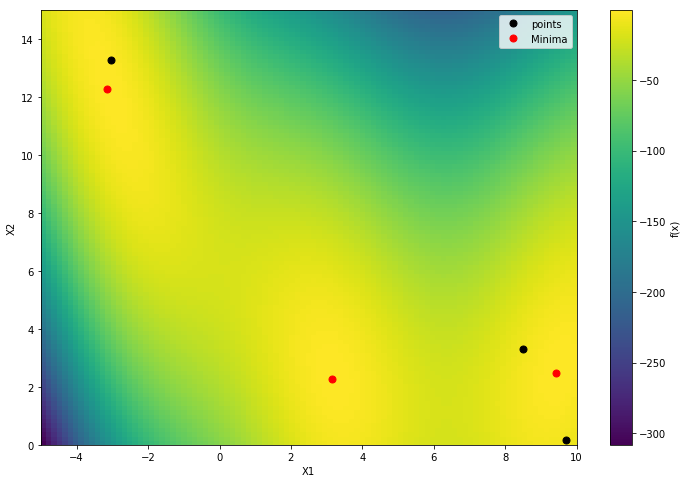

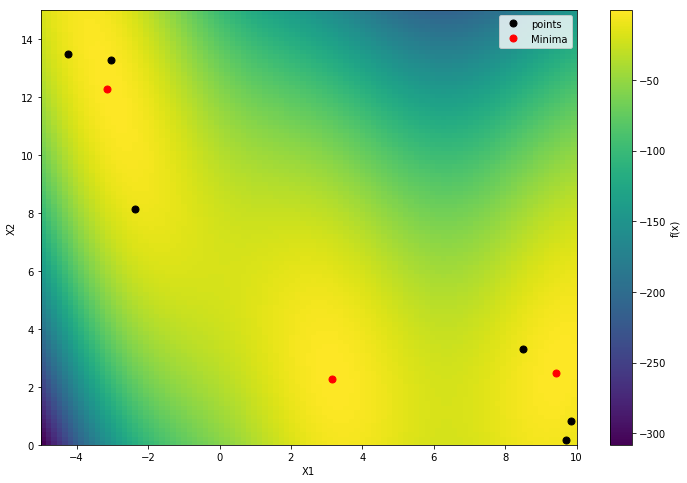

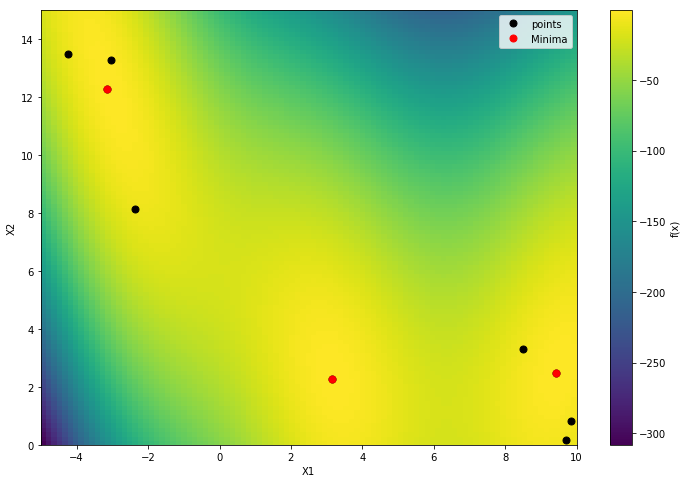

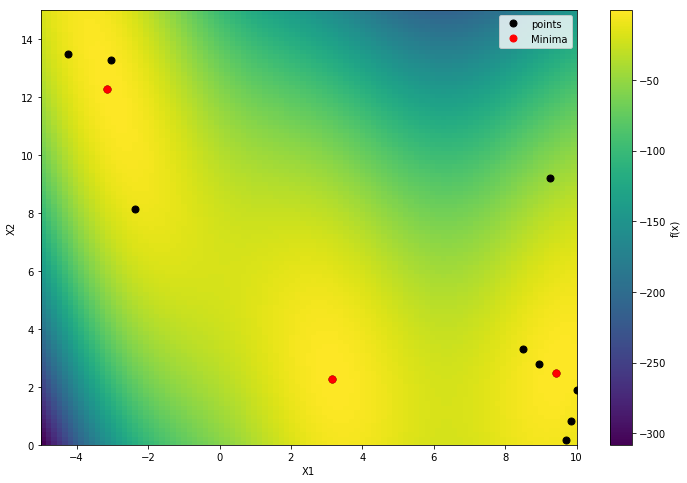

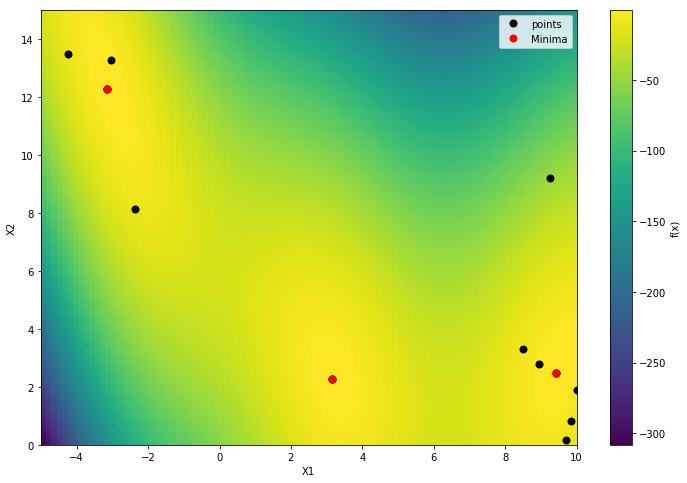

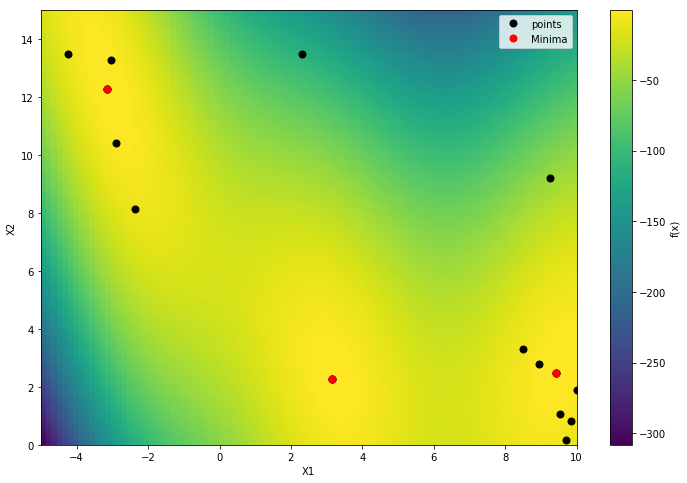

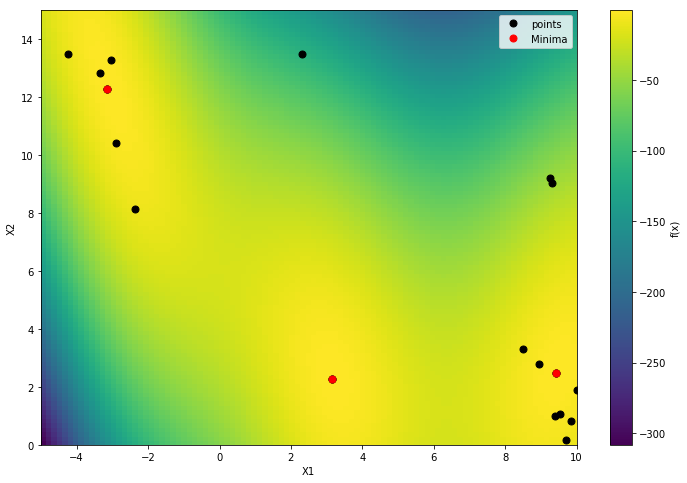

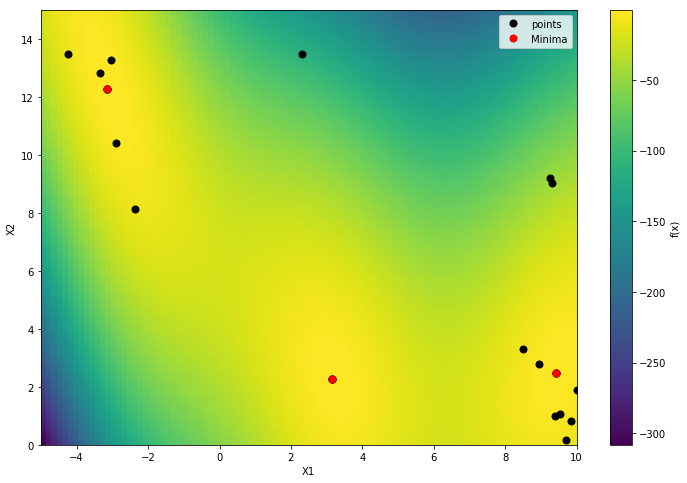

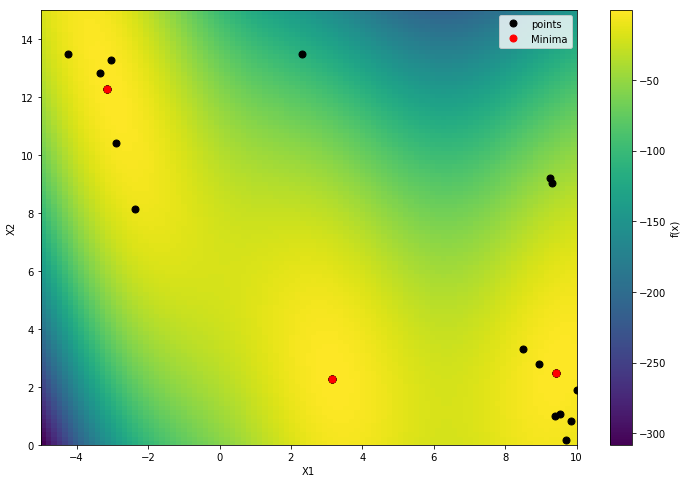

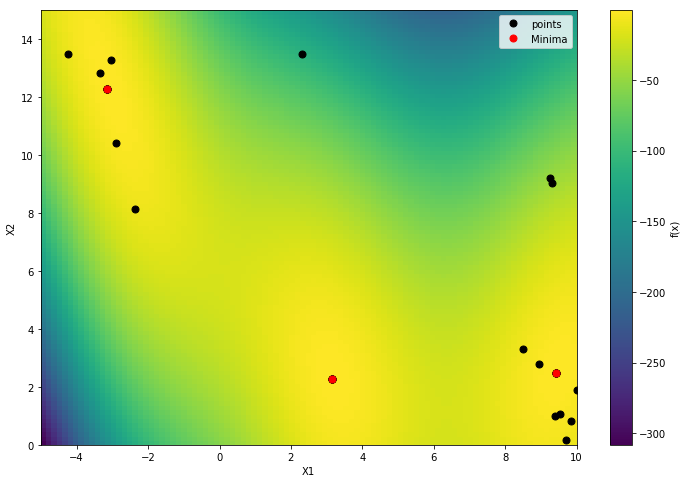

In [17]:
num_dim = 2
num_test_batches = 500
num_sampled_points = 3
num_iter = 10

sampling_strategy = 'manual'
norm = False # we need to do unnormalization of LHS sampled points

Xt = X_train
Yt = Y_train

bb = []
sc = []
bb_array = np.empty((0, 2))
for j in range(num_iter):
    print('Elicitation has started. Eliciting batch num:' + str(j))
    max_obj = np.max(Yt)
    # Train the model on the previous data
    OOPT = Optimizer(bounds)
    OOPT.tell(Xt.tolist(), Yt.tolist())
    model = opt.models[-1]
    
    
    batches = []
    cc_vec = np.zeros(num_test_batches)
    for i in range(num_test_batches):
        if sampling_strategy == 'LHS': 
            b = lhs(num_dim, num_sampled_points)
        if sampling_strategy == 'manual':
            x1_values = np.linspace(-5, 10, 200)
            x2_values = np.linspace(0, 15, 200)
            x_ax, y_ax = np.meshgrid(x1_values, x2_values)
            X_grid = np.zeros(shape = (x_ax.ravel().shape[0], 2))
            X_grid[:,0] = x_ax.ravel()
            X_grid[:,1] = y_ax.ravel()
            rel_ind = np.random.choice(X_grid.shape[0], num_sampled_points, replace=False)
            b = X_grid[rel_ind,:]
        else:
            print ("No such sampling strategy exists ..")
    
        if norm == True:
            #print ('Unnormalizing the LHS sampling based points')
            b[:,0] = b[:,0]*15 - 5.
            b[:,1] = b[:,1]*15
        else:
            b = b
        
        b_model = opt.space.transform(b.tolist())
        batches.append(b)
        mean, covar = model.predict(b_model, return_cov=True)
        cc = qEI.qEI_approx(mean, covar, max_obj)
        cc_num = rpyn.ri2py(cc)
        cc_vec[i] = cc_num
    
    
    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    min_model = opt.space.transform(minima.tolist())
    mean_min, covar_min = model.predict(min_model, return_cov=True)
    cd = qEI.qEI_approx(mean_min, covar_min, max_obj)
    opt_num = rpyn.ri2py(cd)
    
    batches.append(minima)
    cc_vec = np.append(cc_vec, opt_num)
    
    max_qEI_val = np.max(cc_vec)
    max_qEI_val_ind = np.argmax(cc_vec)
    best_batch = batches[max_qEI_val_ind]
    bb.append(best_batch)
    Xt = np.vstack([Xt, best_batch])
    y = neg_branin(np.array(best_batch).T)
    Yt = np.append(Yt, y)
    
    bb_array = np.vstack([bb_array, best_batch])
    
    plot_neg_branin_with_points(bb_array)
    #plot_neg_branin_pred(np.array(best_batch), y_pred, x1_values, x2_values)
    #plot_neg_branin_var(np.array(best_batch), sigma, x1_values, x2_values)

In [18]:
minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
min_model = opt.space.transform(minima.tolist())
mean_min, covar_min = model.predict(min_model, return_cov=True)
cd = qEI.qEI_approx(mean_min, covar_min, max_obj)
opt_num = rpyn.ri2py(cd)

In [19]:
opt_num

array([3.47041194])

In [20]:
minima = np.array([[-np.pi, 6], [+np.pi, 2.275], [9.42478, 2.475]])
min_model = opt.space.transform(minima.tolist())
mean_min, covar_min = model.predict(min_model, return_cov=True)
cd = qEI.qEI_approx(mean_min, covar_min, max_obj)
opt_num = rpyn.ri2py(cd)

In [21]:
opt_num

array([2.55194123])

In [22]:
opt.cand_acq_funcs_

['EI', 'LCB', 'PI']